<a href="https://colab.research.google.com/github/rohinikoli10/Heart_disease_prediction/blob/main/heart_disease.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pandas as pd
import numpy as np
import joblib
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, f1_score
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler, LabelEncoder
from scipy import stats
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping


In [2]:
!pip install shap

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 540.1/540.1 kB 10.6 MB/s eta 0:00:00


In [3]:
import shap

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [5]:
file_path = '/content/heart.csv'
data = pd.read_csv(file_path)

In [6]:
data.head()

,Age,Sex,ChestPainType,RestingBP,Cholesterol,FastingBS,RestingECG,MaxHR,ExerciseAngina,Oldpeak,ST_Slope,HeartDisease
0,40,M,ATA,140,289,0,Normal,172,N,0.0,Up,0
1,49,F,NAP,160,180,0,Normal,156,N,1.0,Flat,1
2,37,M,ATA,130,283,0,ST,98,N,0.0,Up,0
3,48,F,ASY,138,214,0,Normal,108,Y,1.5,Flat,1
4,54,M,NAP,150,195,0,Normal,122,N,0.0,Up,0


In [7]:
print(data.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 918 entries, 0 to 917
Data columns (total 12 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Age             918 non-null    int64  
 1   Sex             918 non-null    object 
 2   ChestPainType   918 non-null    object 
 3   RestingBP       918 non-null    int64  
 4   Cholesterol     918 non-null    int64  
 5   FastingBS       918 non-null    int64  
 6   RestingECG      918 non-null    object 
 7   MaxHR           918 non-null    int64  
 8   ExerciseAngina  918 non-null    object 
 9   Oldpeak         918 non-null    float64
 10  ST_Slope        918 non-null    object 
 11  HeartDisease    918 non-null    int64  
dtypes: float64(1), int64(6), object(5)
memory usage: 86.2+ KB
None


In [8]:
# Remove duplicates

data.drop_duplicates(inplace=True)
print("Data shape after removing duplicates:", data.shape)

Data shape after removing duplicates: (918, 12)


In [9]:
# Correct inaccurate values

for column in data.select_dtypes(include=[np.number]).columns:
    data[column] = np.clip(data[column], data[column].quantile(0.01), data[column].quantile(0.99))

In [10]:
# Handling outliers by removing them
for column in data.select_dtypes(include=[np.number]).columns:
    q1 = data[column].quantile(0.25)
    q3 = data[column].quantile(0.75)
    iqr = q3 - q1
    lower_bound = q1 - 1.5 * iqr
    upper_bound = q3 + 1.5 * iqr
    data = data[(data[column] >= lower_bound) & (data[column] <= upper_bound)]

In [11]:
# Encode categorical variables

label_encoders = {}
for column in data.columns:
    if data[column].dtype == 'object':
        label_encoders[column] = LabelEncoder()
        data[column] = label_encoders[column].fit_transform(data[column])

In [12]:
# Normalize numerical data

scaler = StandardScaler()
numeric_columns = data.select_dtypes(include=[np.number]).columns
data[numeric_columns] = scaler.fit_transform(data[numeric_columns])


In [13]:
# Ensure the target variable is in integer format

data['HeartDisease'] = data['HeartDisease'].astype(int)

In [14]:
# Feature Engineering: Adding interaction terms

data['Age_Cholesterol'] = data['Age'] * data['Cholesterol']
data['Age_MaxHR'] = data['Age'] * data['MaxHR']

In [15]:
# Feature Selection: Correlation-based feature selection

corr_matrix = data.corr()
high_corr_features = corr_matrix.index[abs(corr_matrix['HeartDisease']) > 0.1]
data = data[high_corr_features]

In [16]:
# Separate features and target variable

X = data.drop('HeartDisease', axis=1)
y = data['HeartDisease']

In [17]:
data.head()

,Age,Sex,ChestPainType,RestingBP,MaxHR,ExerciseAngina,Oldpeak,ST_Slope,HeartDisease
0,-1.243980,0.591122,0.148628,0.633140,1.261897,-0.735311,-0.833118,0.916512,0
1,-0.289726,-1.691698,1.212589,1.947796,0.594751,-0.735311,0.208058,-0.830217,1
2,-1.562064,0.591122,0.148628,-0.024188,-1.823654,-0.735311,-0.833118,0.916512,0
3,-0.395754,-1.691698,-0.915333,0.501674,-1.406688,1.359969,0.728645,-0.830217,1
4,0.240415,0.591122,1.212589,1.290468,-0.822935,-0.735311,-0.833118,0.916512,0


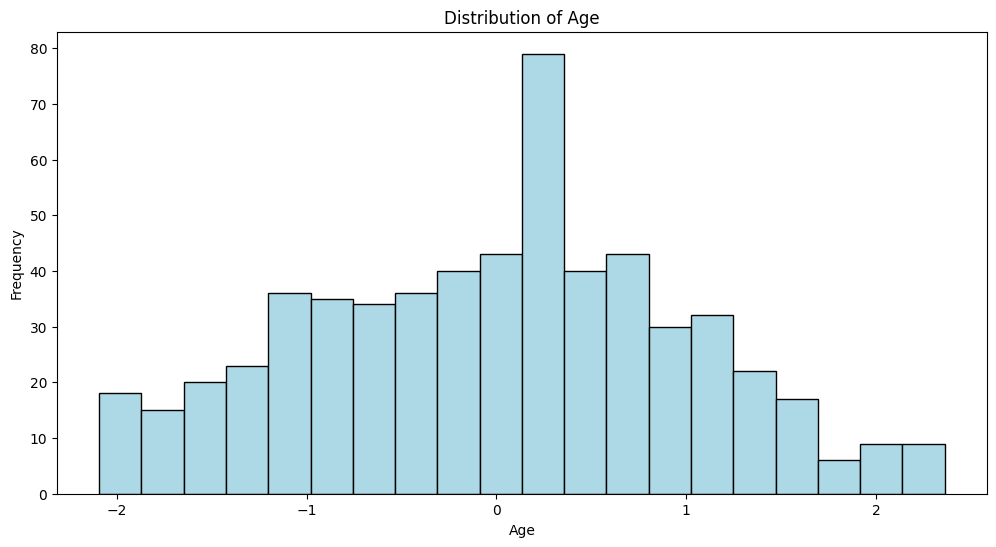

In [18]:
plt.figure(figsize=(12, 6))
plt.hist(data['Age'], bins=20, color='lightblue', edgecolor='black')
plt.title('Distribution of Age')
plt.xlabel('Age')
plt.ylabel('Frequency')
plt.show()

<Figure size 1500x1000 with 0 Axes>

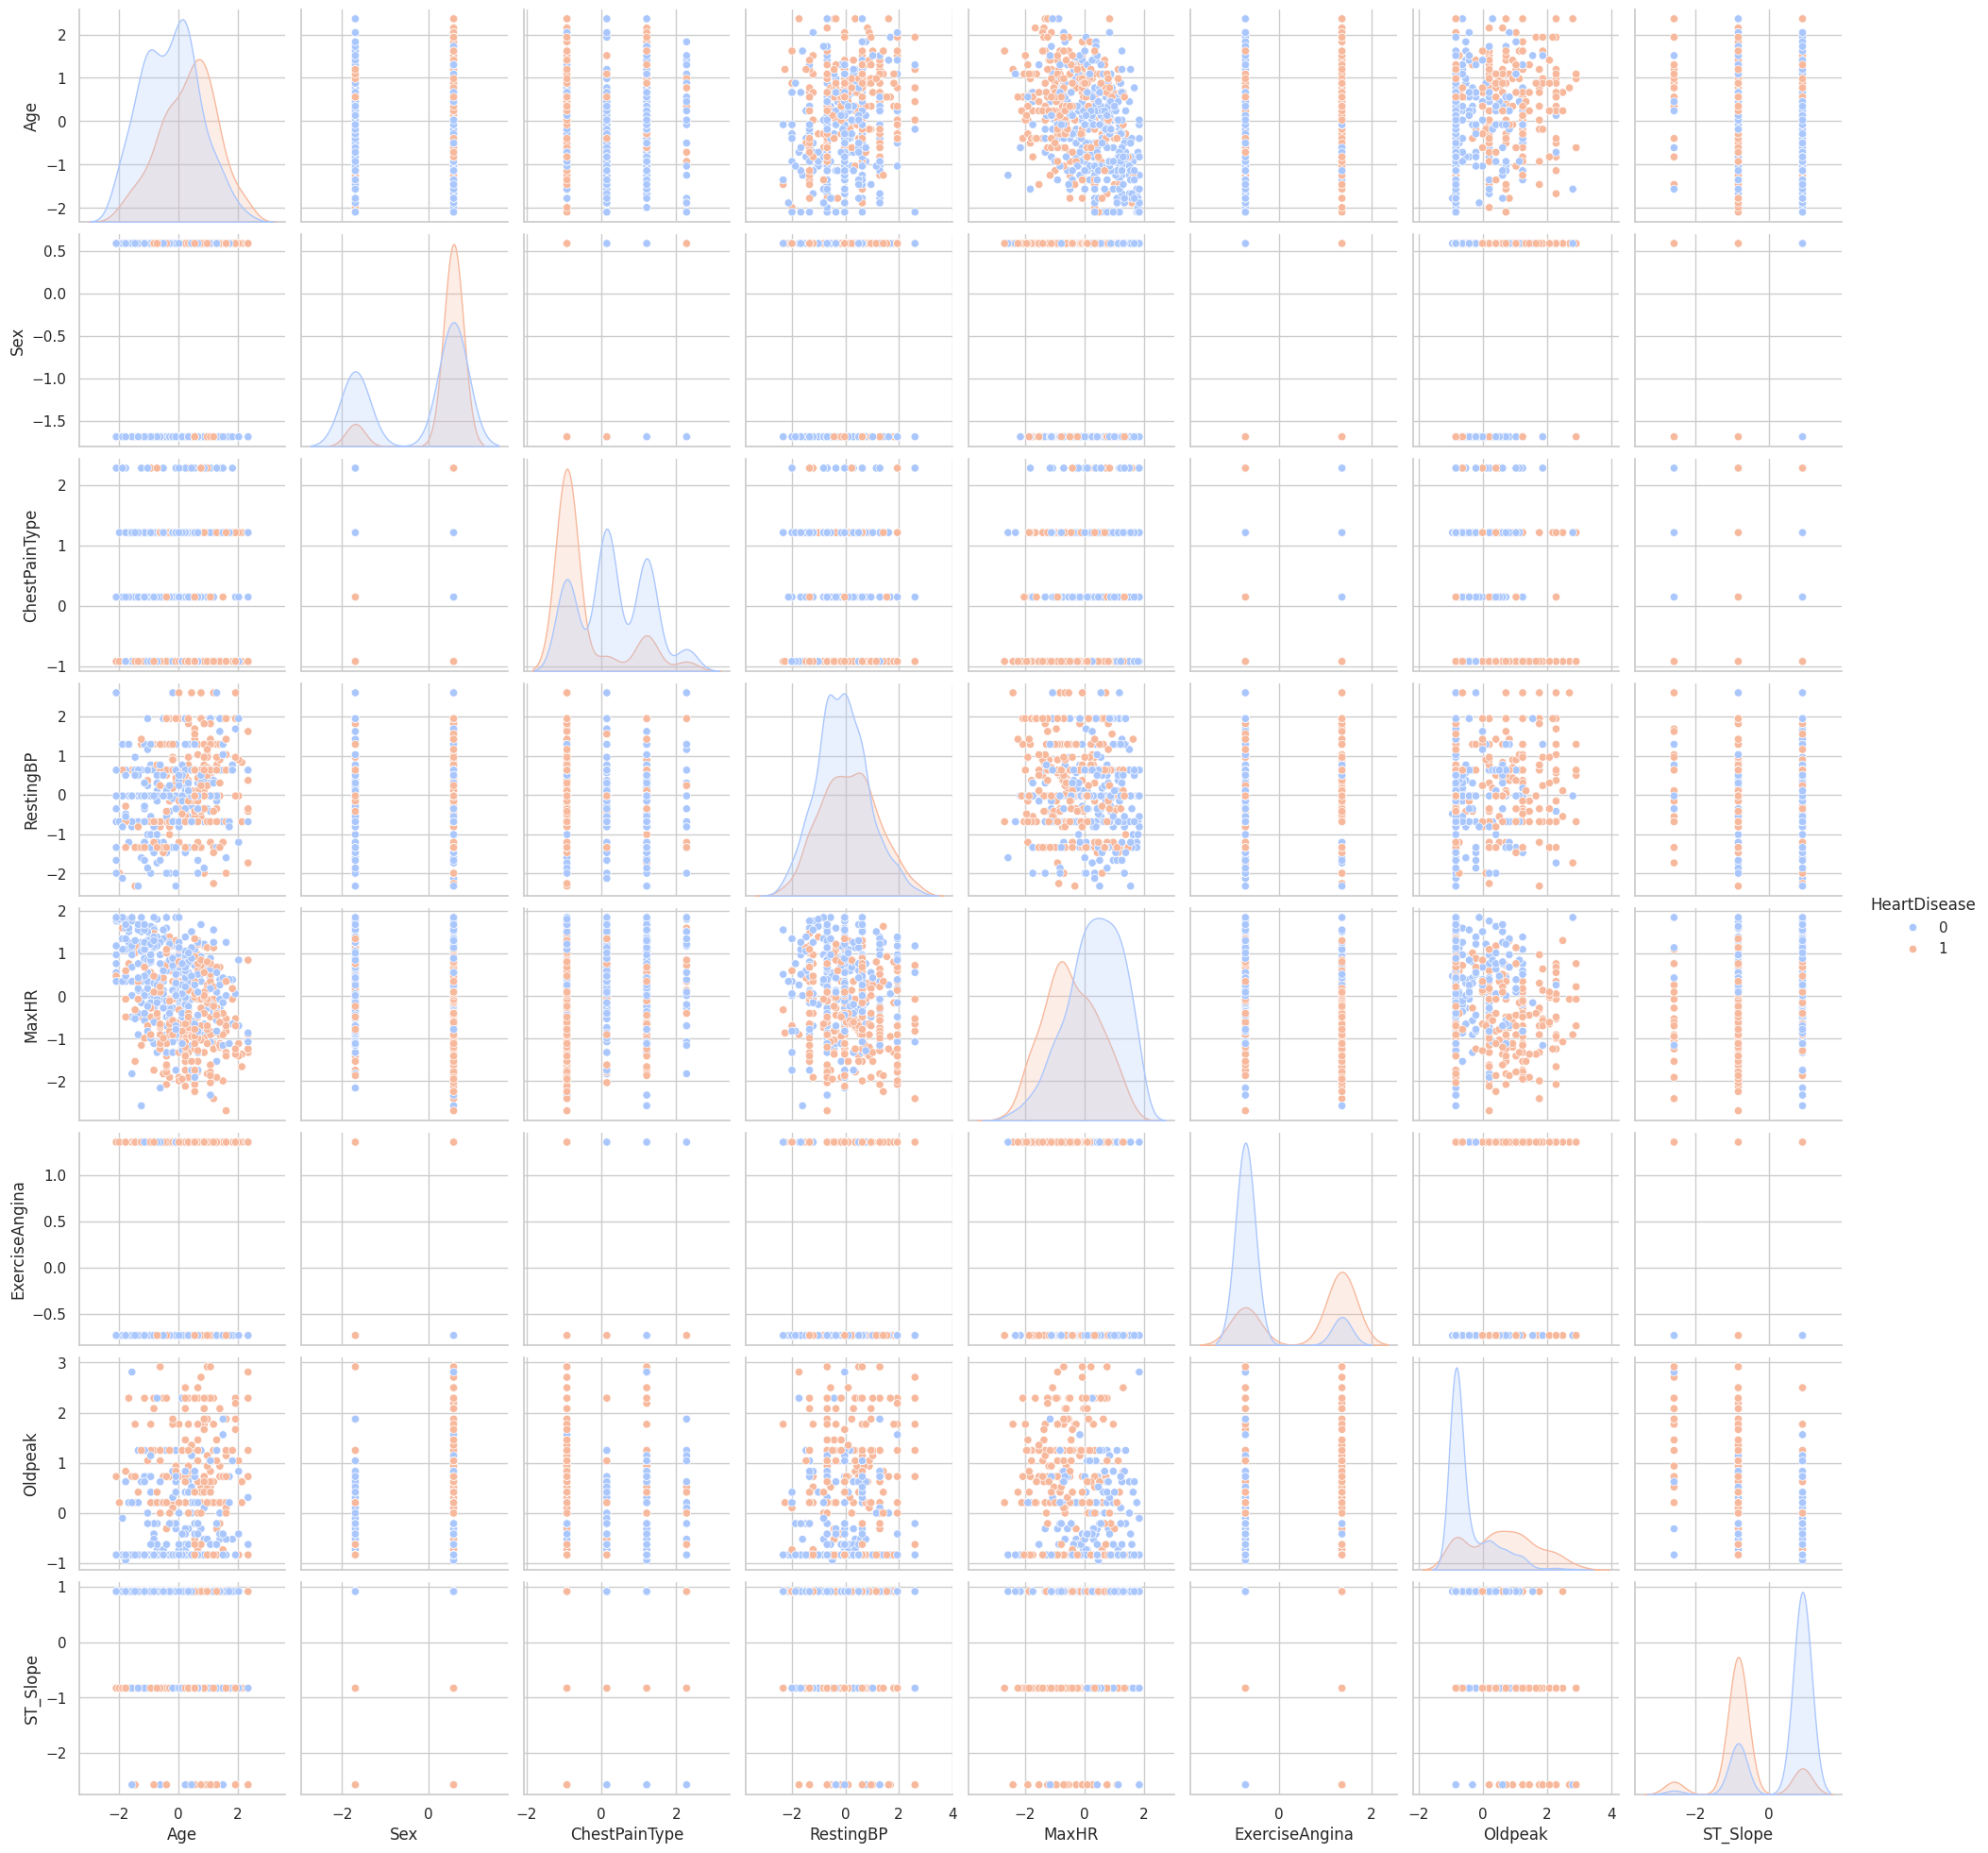

In [19]:
plt.figure(figsize=(15, 10))
sns.set(style="whitegrid", palette="pastel")
sns.pairplot(data, hue='HeartDisease', diag_kind='kde', palette='coolwarm')
plt.show()

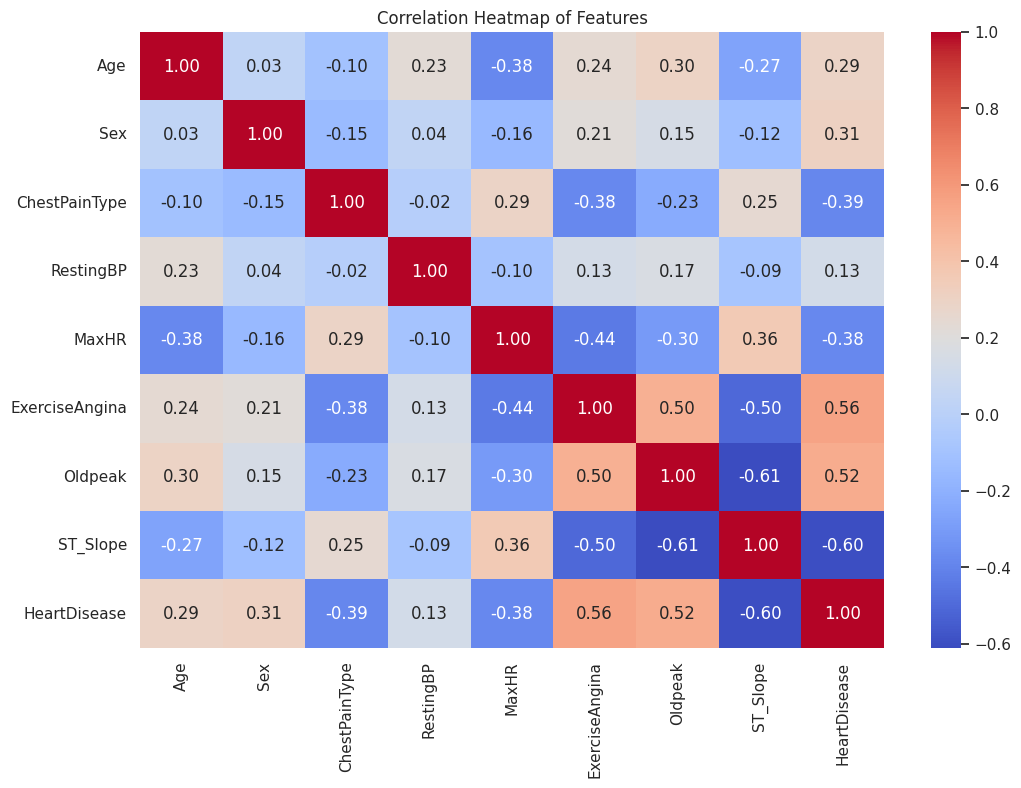

In [20]:
plt.figure(figsize=(12, 8))
sns.heatmap(data.corr(), annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Correlation Heatmap of Features')
plt.show()

In [21]:
# Split the dataset into training and testing sets

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=2)


In [22]:
# Display the shapes of the resulting datasets

print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

(469, 8) (118, 8) (469,) (118,)


In [23]:
# Model 1: Random Forest Classifier with Grid Search
rf = RandomForestClassifier(random_state=42)
param_grid_rf = {
    'n_estimators': [100, 200, 300],
    'max_depth': [10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}
grid_rf = GridSearchCV(estimator=rf, param_grid=param_grid_rf, cv=5, n_jobs=-1, verbose=2)
grid_rf.fit(X_train, y_train)

Fitting 5 folds for each of 81 candidates, totalling 405 fits


/usr/local/lib/python3.10/dist-packages/joblib/externals/loky/backend/fork_exec.py:38: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  pid = os.fork()
/usr/local/lib/python3.10/dist-packages/joblib/externals/loky/backend/fork_exec.py:38: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  pid = os.fork()


GridSearchCV(cv=5, estimator=RandomForestClassifier(random_state=42), n_jobs=-1,
             param_grid={'max_depth': [10, 20, 30],
                         'min_samples_leaf': [1, 2, 4],
                         'min_samples_split': [2, 5, 10],
                         'n_estimators': [100, 200, 300]},
             verbose=2)

In [24]:
best_rf = grid_rf.best_estimator_
y_pred_rf = best_rf.predict(X_test)
print(f"Random Forest Test Accuracy: {accuracy_score(y_test, y_pred_rf)}")

Random Forest Test Accuracy: 0.847457627118644


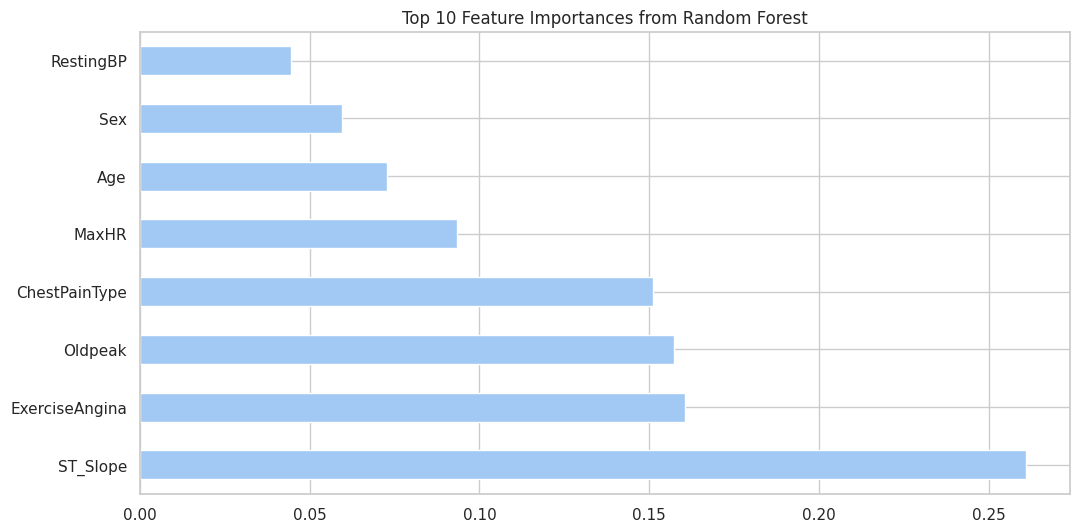

In [25]:
# Additional: Feature Importance from Random Forest
plt.figure(figsize=(12, 6))
feat_importances = pd.Series(best_rf.feature_importances_, index=X.columns)
feat_importances.nlargest(10).plot(kind='barh')
plt.title('Top 10 Feature Importances from Random Forest')
plt.show()

In [26]:
# Model 2: Neural Network with Early Stopping
y_train = to_categorical(y_train)
y_test = to_categorical(y_test)


In [27]:
model = Sequential([
    Dense(128, activation='relu', input_shape=(X_train.shape[1],)),
    Dropout(0.5),
    Dense(64, activation='relu'),
    Dropout(0.5),
    Dense(32, activation='relu'),
    Dense(2, activation='softmax')
])


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [28]:
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [29]:
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
history = model.fit(X_train, y_train, epochs=30, batch_size=32, validation_split=0.2, callbacks=[early_stopping])

Epoch 1/30
12/12 ━━━━━━━━━━━━━━━━━━━━ 2s 26ms/step - accuracy: 0.5177 - loss: 0.6975 - val_accuracy: 0.8723 - val_loss: 0.5654
Epoch 2/30
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.7545 - loss: 0.6035 - val_accuracy: 0.8936 - val_loss: 0.4553
Epoch 3/30
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.7476 - loss: 0.5426 - val_accuracy: 0.8936 - val_loss: 0.3562
Epoch 4/30
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.7821 - loss: 0.4895 - val_accuracy: 0.9149 - val_loss: 0.3015
Epoch 5/30
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.8205 - loss: 0.4382 - val_accuracy: 0.9255 - val_loss: 0.2713
Epoch 6/30
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.8305 - loss: 0.3965 - val_accuracy: 0.9255 - val_loss: 0.2579
Epoch 7/30
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.8301 - loss: 0.4053 - val_accuracy: 0.9362 - val_loss: 0.2589
Epoch 8/30
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.8295 - loss: 0.4412 - val_accuracy: 0.9362 - val_loss

In [30]:
test_loss, test_accuracy = model.evaluate(X_test, y_test)
print(f'Test Accuracy (Neural Network): {test_accuracy}')

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9010 - loss: 0.2726 
Test Accuracy (Neural Network): 0.8644067645072937


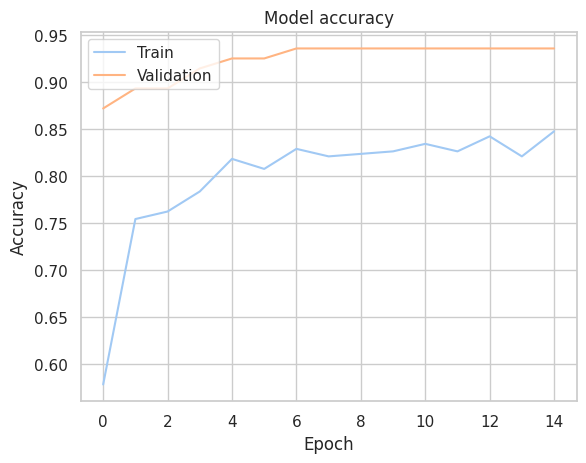

In [31]:
# Visualization of Model Performance
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

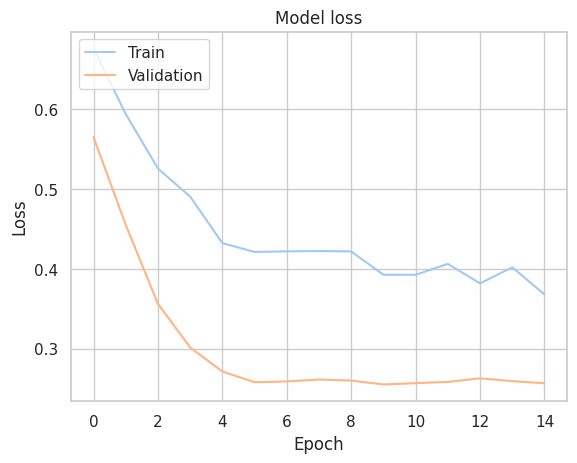

In [32]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

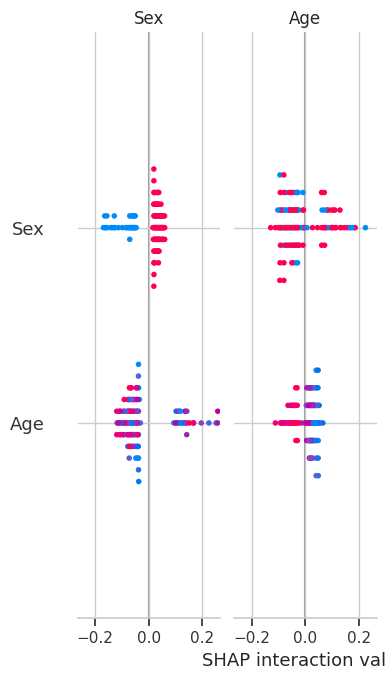

In [33]:
# Model Interpretability: SHAP Values for Random Forest
explainer = shap.TreeExplainer(best_rf)
shap_values = explainer.shap_values(X_test)
shap.summary_plot(shap_values, X_test, plot_type="bar")

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


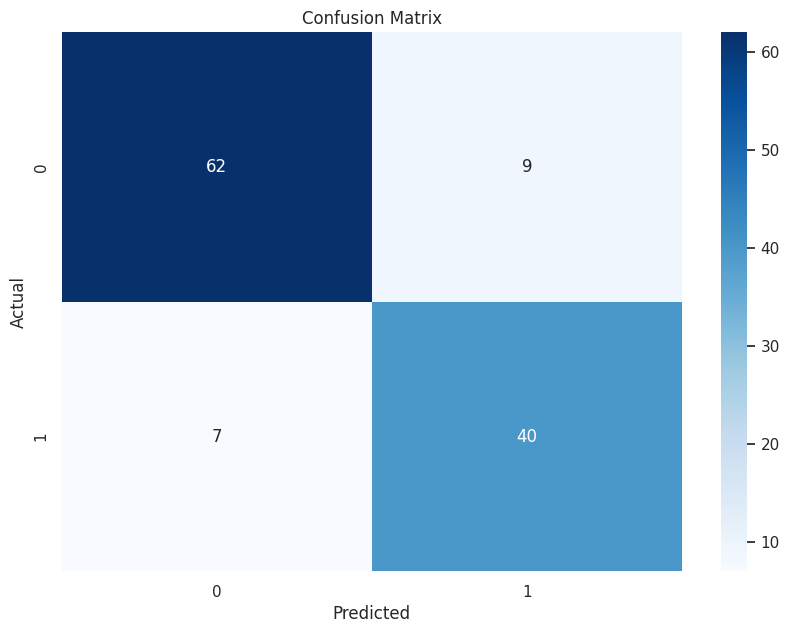

In [34]:
# Visualization of Confusion Matrix
conf_matrix = confusion_matrix(np.argmax(y_test, axis=1), np.argmax(model.predict(X_test), axis=1))
plt.figure(figsize=(10, 7))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap='Blues')
plt.title('Confusion Matrix')
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()